### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import json
import os

os.environ["WANDB_DISABLED"] = "true"

C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random Seeds

In [2]:
import random
from transformers import set_seed

# Set the random seed for reproducibility
seed = 42  # You can use any integer value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
set_seed(seed)  # For transformers

### Load dataset

Condition
- 0: F2F
- 1: Online

In [3]:
# Transcript and prediction targets
video_path = "E:/GAR/videos"
df = {rnd: pd.read_csv(os.path.join(video_path, f"G4_{rnd}_tsrc_whisper.csv")) for rnd in ['R1', 'R2', 'R3']}

# Some F2F courses were mistakenly recorded as Online Courses
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Cotulla David Rodriguez Day 1 weather', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Jim Hogg Aaron Salazar Week 3 Day 1.mp4', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Kopperl Debbie Beavers', 'Condition'] = 0

### Define the functions

In [4]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(labels, predictions, average='weighted', zero_division=1)
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [5]:
from datasets import Dataset
import joblib

def tokenize_and_save(df, target, rnd, setting, video_path, results_dir, dataset_dir):
    
    # df = df[rnd]
    df = df[df['Condition'] == setting][['tsrc', target]]
    df = df.fillna(' ')

    # Encode the target column
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[target])
    
    # Save the label mapping to a JSON file
    label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
    mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
    with open(mapping_file_path, "w") as json_file:
        json.dump(label_mapping, json_file, indent=4)
    print(f"Label mapping saved to: {mapping_file_path}")
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(example):
        return tokenizer(example["tsrc"], truncation=True, padding="max_length", max_length=512)

    # Split dataset
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)
    
    for split, dataset in zip(["train", "val", "test"], [train_df, val_df, test_df]):
        dataset = Dataset.from_pandas(dataset)  # Convert DataFrame to Dataset
        dataset = dataset.map(tokenize_function, batched=True)  # Now `batched=True` works
        dataset = dataset.remove_columns(["tsrc"])
        dataset.set_format("numpy")
        joblib.dump(dataset, os.path.join(dataset_dir, f"{split}_dataset.joblib"))

    tokenizer.save_pretrained(results_dir)  # Save tokenizer
    
    return df

In [6]:
# dataset_dir = './datasets0227_rf/R123/1/Lang. of Instruction(S)'
# ex = joblib.load(os.path.join(dataset_dir, "train_dataset.joblib"))

In [7]:
# for num, a in enumerate(ex):
#     print(a)
#     print()

#     if num > 5:
#         break

In [8]:
def training_evaluation(video_path, results_dir, output_dir, num_labels, label_mapping):
    
    # Load tokenized datasets
    train_dataset = joblib.load(os.path.join(dataset_dir, "train_dataset.joblib"))
    val_dataset = joblib.load(os.path.join(dataset_dir, "val_dataset.joblib"))
    test_dataset = joblib.load(os.path.join(dataset_dir, "test_dataset.joblib"))

    train_dataset = train_dataset.remove_columns(["__index_level_0__"])
    val_dataset = val_dataset.remove_columns(["__index_level_0__"])
    test_dataset = test_dataset.remove_columns(["__index_level_0__"])
    
    train_dataset.set_format("torch")
    val_dataset.set_format("torch")
    test_dataset.set_format("torch")
    # Define the Model
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",  # Perform evaluation after each epoch
        save_strategy="epoch",        # Save model after each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=30,
        weight_decay=0.01,
        logging_dir="./logs",
        save_total_limit=1,           # Keep only the best model
        load_best_model_at_end=True,  # Automatically load the best model
        metric_for_best_model="f1",   # Track f1 score for the best model
        greater_is_better=True,       # Higher metric is better
    )
    
    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
    
    # Train the Model
    trainer.train()
    
    # Save the trained model and tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved in: {output_dir}")
    
    # Evaluate on Test Set
    test_results = trainer.predict(test_dataset)
    predictions = np.argmax(test_results.predictions, axis=1)
    true_labels = test_results.label_ids
    
    # Get top-3 predictions
    top_n = 3
    sorted_indices = np.argsort(test_results.predictions, axis=1)[:, -top_n:][:, ::-1]
    
    def top_n_accuracy(true_labels, sorted_indices, n):
        binary_predictions = [1 if true_labels[i] in sorted_indices[i, :n] else 0 for i in range(len(true_labels))]
        return np.mean(binary_predictions)
    
    # Calculate metrics
    top1_accuracy = accuracy_score(true_labels, sorted_indices[:, 0])
    top1_precision = precision_score(true_labels, sorted_indices[:, 0], average="weighted", zero_division=1)
    top1_recall = recall_score(true_labels, sorted_indices[:, 0], average="weighted", zero_division=1)
    top1_f1 = f1_score(true_labels, sorted_indices[:, 0], average="weighted")
    top2_accuracy = top_n_accuracy(true_labels, sorted_indices, 2)
    top3_accuracy = top_n_accuracy(true_labels, sorted_indices, 3)

    # Confusion Matrix (for top-1 predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    # Get the encoded labels that appear in the confusion matrix
    unique_labels = sorted(set(true_labels) | set(predictions))
    print(unique_labels)
    
    # Convert label indices back to original labels using label_mapping
    original_labels = [label_mapping[label] for label in unique_labels]
    print(original_labels)
    
    # Display and save the confusion matrix with original labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_labels)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"Confusion Matrix ({target} Top-1 Predictions)")
    
    cm_path = os.path.join(results_dir, f"confusion_matrix_{target}_top1.png")
    plt.savefig(cm_path)
    plt.show()
    plt.close()
    
    # Save metrics to JSON
    metrics = {
        "top1": {"accuracy": top1_accuracy, "precision": top1_precision, "recall": top1_recall, "f1": top1_f1},
        "top2": {"accuracy": top2_accuracy},
        "top3": {"accuracy": top3_accuracy},
    }
    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
    print("Evaluation Metrics:", metrics)




---------------------- Tokenize and save dataset R123, Setting 0, ESL Strategy ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/ESL Strategy\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/ESL Strategy\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 749/749 [00:00<00:00, 1362.51 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.504526,0.469251,0.549048,0.469251,0.435963
2,1.620700,1.438095,0.475936,0.494698,0.475936,0.452950
3,1.620700,1.474694,0.494652,0.528626,0.494652,0.470848
4,1.018700,1.602392,0.495989,0.502174,0.495989,0.482884
5,1.018700,1.912031,0.500000,0.506309,0.500000,0.493026
6,0.494800,2.112025,0.483957,0.483686,0.483957,0.477883
7,0.494800,2.345389,0.508021,0.516439,0.508021,0.504520
8,0.280800,2.562212,0.521390,0.538746,0.521390,0.510195
9,0.191200,2.743368,0.502674,0.517166,0.502674,0.497191
10,0.191200,2.800184,0.516043,0.529620,0.516043,0.514152


Model and tokenizer saved in: ./models0227_bert1/R123/0/ESL Strategy


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9)]
['1', '2', '3', '4', '5', '6', '7', '9', '10']


<Figure size 1000x800 with 0 Axes>

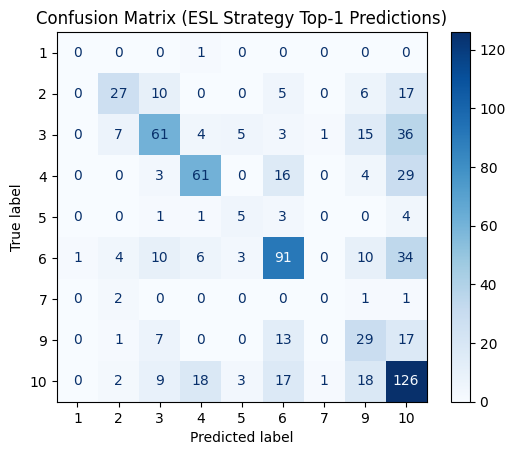

Evaluation Metrics: {'top1': {'accuracy': 0.5340453938584779, 'precision': 0.553301788613474, 'recall': 0.5340453938584779, 'f1': 0.5350742175327495}, 'top2': {'accuracy': np.float64(0.7116154873164219)}, 'top3': {'accuracy': np.float64(0.8104138851802403)}}



---------------------- Tokenize and save dataset R123, Setting 0, Curriculum ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Curriculum\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Curriculum\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1415.79 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.054177,0.993316,0.993360,0.993316,0.989984
2,0.082300,0.056488,0.993316,0.993360,0.993316,0.989984
3,0.082300,0.054739,0.993316,0.993360,0.993316,0.989984


Model and tokenizer saved in: ./models0227_bert1/R123/0/Curriculum


[np.int64(2), np.int64(3)]
['4', '5']


<Figure size 1000x800 with 0 Axes>

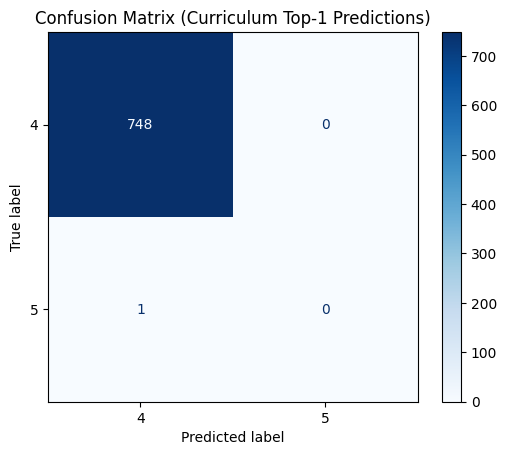

Evaluation Metrics: {'top1': {'accuracy': 0.9986648865153538, 'precision': 0.9986666690433706, 'recall': 0.9986648865153538, 'f1': 0.9979977757027183}, 'top2': {'accuracy': np.float64(0.9986648865153538)}, 'top3': {'accuracy': np.float64(0.9986648865153538)}}



---------------------- Tokenize and save dataset R123, Setting 0, Physical Group ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Physical Group\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Physical Group\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1453.89 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.994029,0.613636,0.633537,0.613636,0.578862
2,0.922600,1.016527,0.622995,0.543451,0.622995,0.541930
3,0.922600,1.184354,0.608289,0.564481,0.608289,0.568011


Model and tokenizer saved in: ./models0227_bert1/R123/0/Physical Group


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
['1', '2', '3', '4', '5']


<Figure size 1000x800 with 0 Axes>

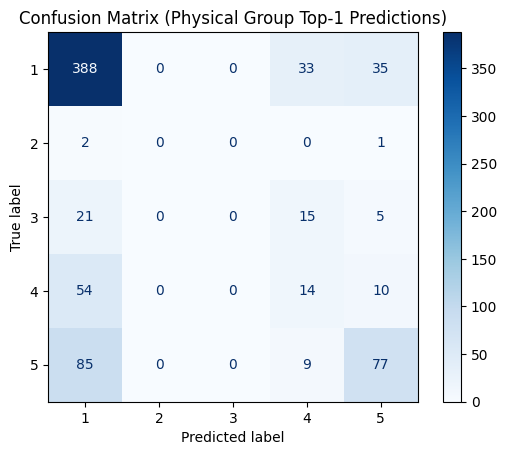

Evaluation Metrics: {'top1': {'accuracy': 0.6395193591455274, 'precision': 0.646107799622715, 'recall': 0.6395193591455274, 'f1': 0.6067781355875692}, 'top2': {'accuracy': np.float64(0.8544726301735648)}, 'top3': {'accuracy': np.float64(0.931909212283044)}}



---------------------- Tokenize and save dataset R123, Setting 0, Activity Structure ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Activity Structure\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Activity Structure\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1388.00 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,2.017179,0.347594,0.520801,0.347594,0.280953
2,2.099200,1.890333,0.391711,0.565833,0.391711,0.328394
3,2.099200,1.866276,0.417112,0.481675,0.417112,0.377043
4,1.410600,1.998061,0.385027,0.465671,0.385027,0.356085
5,1.410600,2.115292,0.430481,0.497423,0.430481,0.401266
6,0.901300,2.218166,0.425134,0.472614,0.425134,0.404445
7,0.901300,2.380395,0.423797,0.470299,0.423797,0.403879
8,0.563200,2.552253,0.419786,0.438091,0.419786,0.407197
9,0.375300,2.713201,0.415775,0.425382,0.415775,0.402653
10,0.375300,2.789199,0.423797,0.431974,0.423797,0.411116


Model and tokenizer saved in: ./models0227_bert1/R123/0/Activity Structure


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(20)]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '19', '21']


<Figure size 1000x800 with 0 Axes>

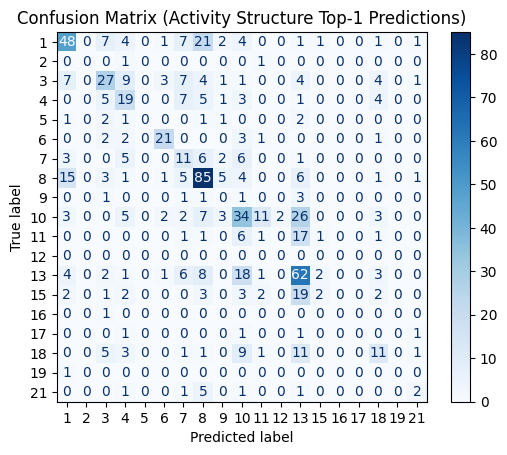

Evaluation Metrics: {'top1': {'accuracy': 0.43124165554072097, 'precision': 0.44490044691294667, 'recall': 0.43124165554072097, 'f1': 0.4176034160335135}, 'top2': {'accuracy': np.float64(0.57543391188251)}, 'top3': {'accuracy': np.float64(0.6608811748998665)}}



---------------------- Tokenize and save dataset R123, Setting 0, Mode ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Mode\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Mode\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1444.68 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.787649,0.421123,0.607356,0.421123,0.338742
2,1.818800,1.767051,0.445187,0.595920,0.445187,0.391778
3,1.818800,1.827754,0.435829,0.537207,0.435829,0.381851
4,1.289500,1.936001,0.434492,0.536715,0.434492,0.413012
5,1.289500,2.163654,0.438503,0.519163,0.438503,0.404468
6,0.837500,2.357351,0.437166,0.511288,0.437166,0.414476
7,0.837500,2.644825,0.437166,0.460550,0.437166,0.417924
8,0.563900,2.783405,0.427807,0.473969,0.427807,0.414532
9,0.421900,2.939929,0.410428,0.441029,0.410428,0.400895


Model and tokenizer saved in: ./models0227_bert1/R123/0/Mode


[np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
['1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '14', '15', '16', '17']


<Figure size 1000x800 with 0 Axes>

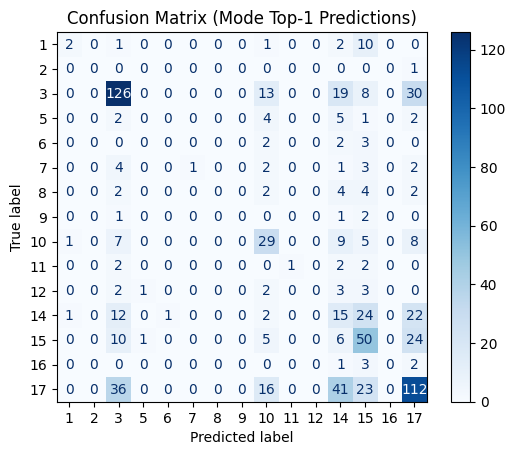

Evaluation Metrics: {'top1': {'accuracy': 0.4485981308411215, 'precision': 0.501225637348806, 'recall': 0.4485981308411215, 'f1': 0.43484655502636826}, 'top2': {'accuracy': np.float64(0.6408544726301736)}, 'top3': {'accuracy': np.float64(0.7102803738317757)}}



---------------------- Tokenize and save dataset R123, Setting 0, Language Content ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Language Content\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Language Content\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1410.32 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.399931,0.909091,0.917355,0.909091,0.865801
2,0.384700,0.412339,0.909091,0.917355,0.909091,0.865801
3,0.384700,0.362368,0.910428,0.896848,0.910428,0.888174
4,0.258700,0.473338,0.901070,0.873645,0.901070,0.881407
5,0.258700,0.592464,0.885027,0.864293,0.885027,0.867925


Model and tokenizer saved in: ./models0227_bert1/R123/0/Language Content


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

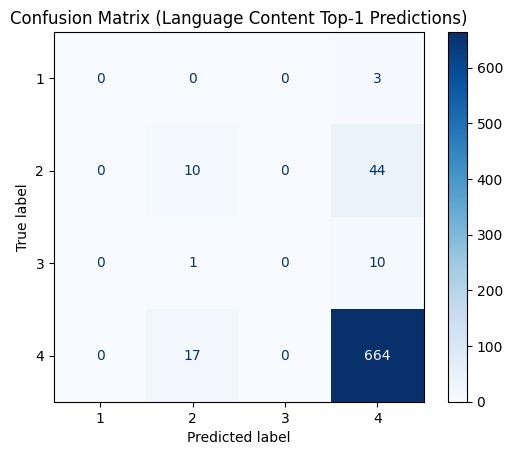

Evaluation Metrics: {'top1': {'accuracy': 0.8998664886515354, 'precision': 0.881773015893591, 'recall': 0.8998664886515354, 'f1': 0.8788068978834913}, 'top2': {'accuracy': np.float64(0.9813084112149533)}, 'top3': {'accuracy': np.float64(0.9946595460614153)}}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1427.40 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.377869,0.879679,0.894156,0.879679,0.823370
2,0.291800,0.316122,0.879679,0.894156,0.879679,0.823370
3,0.291800,0.352333,0.862299,0.859208,0.862299,0.859353
4,0.192100,0.456234,0.889037,0.870242,0.889037,0.872030
5,0.192100,0.473681,0.879679,0.842633,0.879679,0.840821
6,0.113900,0.519192,0.871658,0.825776,0.871658,0.835773


Model and tokenizer saved in: ./models0227_bert1/R123/0/Lang. of Instruction(T)


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

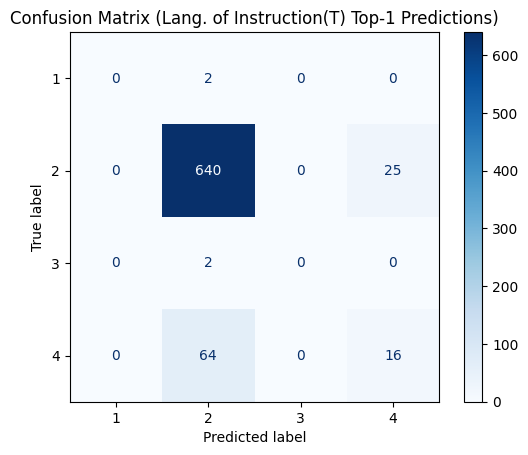

Evaluation Metrics: {'top1': {'accuracy': 0.8758344459279038, 'precision': 0.8495987392495953, 'recall': 0.8758344459279038, 'f1': 0.8559590452152492}, 'top2': {'accuracy': np.float64(0.9946595460614153)}, 'top3': {'accuracy': np.float64(0.9959946595460614)}}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_bert1/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 749/749 [00:00<00:00, 1476.96 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.572208,0.732620,0.731361,0.732620,0.730570
2,0.579300,0.586984,0.727273,0.730961,0.727273,0.727643
3,0.579300,0.725787,0.723262,0.727918,0.723262,0.724026


Model and tokenizer saved in: ./models0227_bert1/R123/0/Lang. of Instruction(S)


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '4', '5']


<Figure size 1000x800 with 0 Axes>

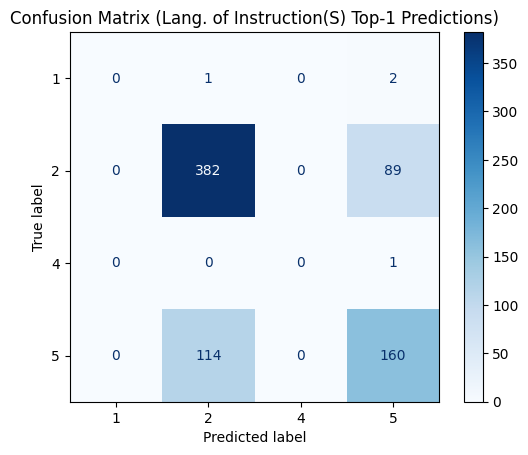

Evaluation Metrics: {'top1': {'accuracy': 0.7236315086782377, 'precision': 0.7209403879141933, 'recall': 0.7236315086782377, 'f1': 0.7188674027110988}, 'top2': {'accuracy': np.float64(0.9946595460614153)}, 'top3': {'accuracy': np.float64(0.9986648865153538)}}



---------------------- Tokenize and save dataset R123, Setting 1, ESL Strategy ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/ESL Strategy\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/ESL Strategy\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1395.87 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.608663,0.428571,0.620784,0.428571,0.343786
2,No log,1.455324,0.498168,0.581809,0.498168,0.461530
3,1.509000,1.424162,0.534799,0.593834,0.534799,0.497227
4,1.509000,1.580995,0.490842,0.514227,0.490842,0.483187
5,0.737200,1.771423,0.505495,0.516452,0.505495,0.480735


Model and tokenizer saved in: ./models0227_bert1/R123/1/ESL Strategy


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
['1', '2', '3', '4', '5', '6', '7', '8', '9']


<Figure size 1000x800 with 0 Axes>

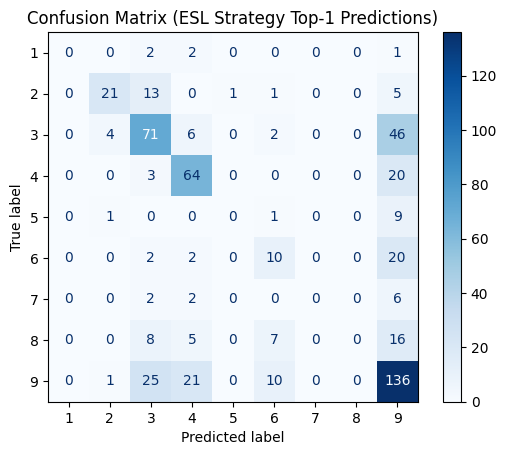

Evaluation Metrics: {'top1': {'accuracy': 0.5531135531135531, 'precision': 0.5906208272025566, 'recall': 0.5531135531135531, 'f1': 0.5177336810108776}, 'top2': {'accuracy': np.float64(0.7564102564102564)}, 'top3': {'accuracy': np.float64(0.8644688644688645)}}



---------------------- Tokenize and save dataset R123, Setting 1, Curriculum ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Curriculum\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Curriculum\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1424.67 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.116938,0.979853,0.980259,0.979853,0.969883
2,No log,0.116996,0.979853,0.980259,0.979853,0.969883
3,0.167000,0.128838,0.979853,0.980259,0.979853,0.969883


Model and tokenizer saved in: ./models0227_bert1/R123/1/Curriculum


[np.int64(0), np.int64(3), np.int64(4)]
['1', '5', '13']


<Figure size 1000x800 with 0 Axes>

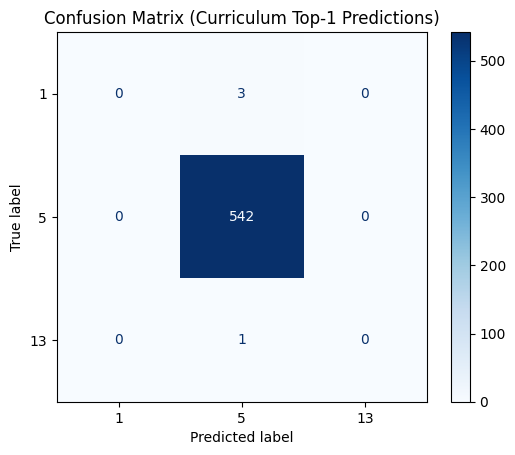

Evaluation Metrics: {'top1': {'accuracy': 0.9926739926739927, 'precision': 0.9927276630573334, 'recall': 0.9926739926739927, 'f1': 0.9890244559362207}, 'top2': {'accuracy': np.float64(0.9981684981684982)}, 'top3': {'accuracy': np.float64(0.9981684981684982)}}



---------------------- Tokenize and save dataset R123, Setting 1, Physical Group ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Physical Group\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Physical Group\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1422.81 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.677320,0.732601,0.741238,0.732601,0.707290
2,No log,0.657634,0.760073,0.777550,0.760073,0.722244
3,0.630300,0.837702,0.741758,0.756571,0.741758,0.721123
4,0.630300,1.093627,0.752747,0.751688,0.752747,0.720787


Model and tokenizer saved in: ./models0227_bert1/R123/1/Physical Group


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

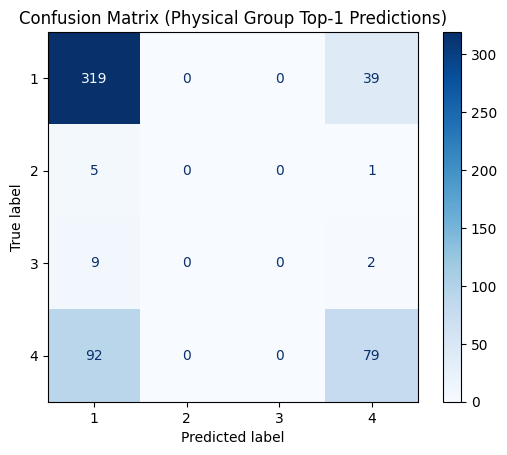

Evaluation Metrics: {'top1': {'accuracy': 0.7289377289377289, 'precision': 0.7277568064733839, 'recall': 0.7289377289377289, 'f1': 0.7037199651354902}, 'top2': {'accuracy': np.float64(0.9743589743589743)}, 'top3': {'accuracy': np.float64(0.9871794871794872)}}



---------------------- Tokenize and save dataset R123, Setting 1, Activity Structure ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Activity Structure\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Activity Structure\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1416.98 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.970630,0.434066,0.603770,0.434066,0.354448
2,No log,1.755053,0.489011,0.538880,0.489011,0.425223
3,1.976900,1.757928,0.494505,0.542453,0.494505,0.463105
4,1.976900,1.848862,0.474359,0.531296,0.474359,0.449060
5,1.025800,2.111338,0.445055,0.493465,0.445055,0.428925


Model and tokenizer saved in: ./models0227_bert1/R123/1/Activity Structure


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


<Figure size 1000x800 with 0 Axes>

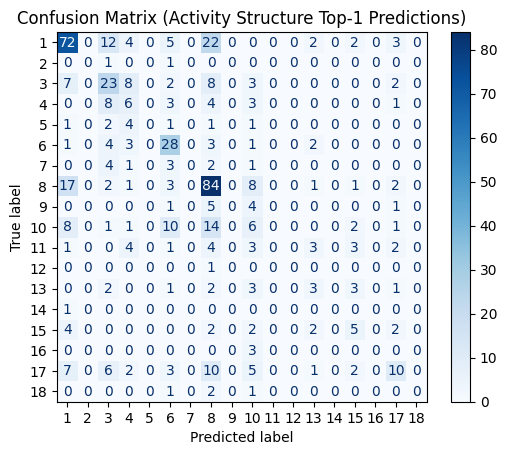

Evaluation Metrics: {'top1': {'accuracy': 0.4340659340659341, 'precision': 0.499631442104679, 'recall': 0.4340659340659341, 'f1': 0.40024635514158097}, 'top2': {'accuracy': np.float64(0.5879120879120879)}, 'top3': {'accuracy': np.float64(0.6904761904761905)}}



---------------------- Tokenize and save dataset R123, Setting 1, Mode ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Mode\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Mode\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1420.43 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.645066,0.489011,0.630181,0.489011,0.408056
2,No log,1.609257,0.481685,0.597274,0.481685,0.396812
3,1.622000,1.685966,0.467033,0.492565,0.467033,0.429886
4,1.622000,1.959048,0.461538,0.487775,0.461538,0.413949
5,0.852900,2.021992,0.481685,0.530342,0.481685,0.464841
6,0.852900,2.338307,0.483516,0.460265,0.483516,0.446677
7,0.852900,2.490869,0.487179,0.513962,0.487179,0.457353


Model and tokenizer saved in: ./models0227_bert1/R123/1/Mode


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['1', '2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


<Figure size 1000x800 with 0 Axes>

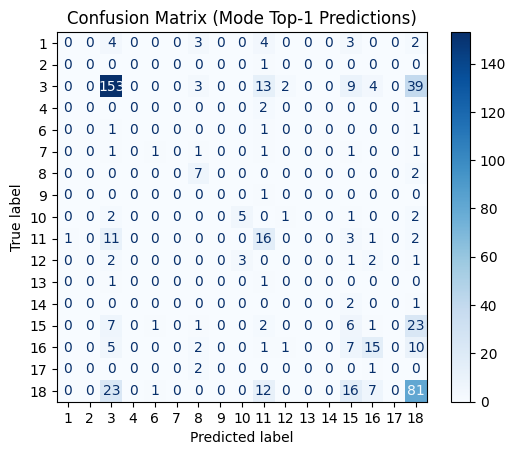

Evaluation Metrics: {'top1': {'accuracy': 0.5183150183150184, 'precision': 0.5397902893566936, 'recall': 0.5183150183150184, 'f1': 0.5069146031711641}, 'top2': {'accuracy': np.float64(0.6684981684981685)}, 'top3': {'accuracy': np.float64(0.7673992673992674)}}



---------------------- Tokenize and save dataset R123, Setting 1, Language Content ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Language Content\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Language Content\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1365.79 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.479082,0.835165,0.848967,0.835165,0.819536
2,No log,0.470248,0.860806,0.865220,0.860806,0.840526
3,0.489500,0.568289,0.864469,0.860719,0.864469,0.836928
4,0.489500,0.636586,0.855311,0.843744,0.855311,0.838956


Model and tokenizer saved in: ./models0227_bert1/R123/1/Language Content


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

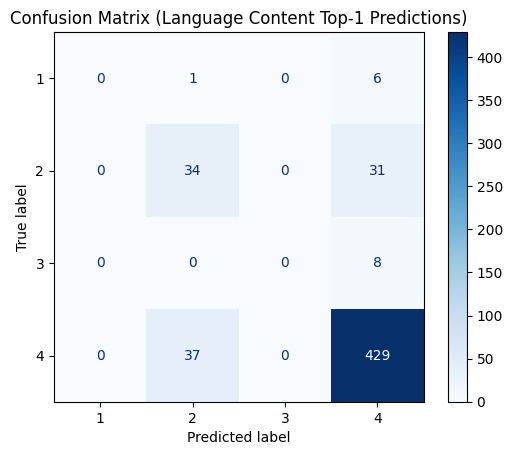

Evaluation Metrics: {'top1': {'accuracy': 0.847985347985348, 'precision': 0.8561427438009718, 'recall': 0.847985347985348, 'f1': 0.8381166847854222}, 'top2': {'accuracy': np.float64(0.9743589743589743)}, 'top3': {'accuracy': np.float64(0.9853479853479854)}}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1354.68 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.359659,0.904762,0.895025,0.904762,0.887737
2,No log,0.341911,0.913919,0.907935,0.913919,0.900283
3,0.300300,0.430420,0.904762,0.898298,0.904762,0.891822
4,0.300300,0.387443,0.904762,0.899457,0.904762,0.895387


Model and tokenizer saved in: ./models0227_bert1/R123/1/Lang. of Instruction(T)


[np.int64(0), np.int64(1), np.int64(3)]
['1', '2', '4']


<Figure size 1000x800 with 0 Axes>

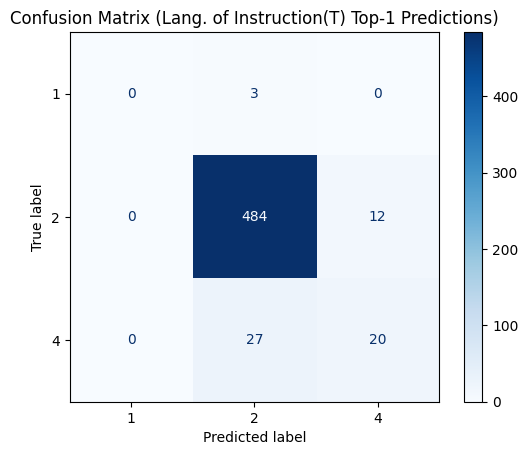

Evaluation Metrics: {'top1': {'accuracy': 0.9230769230769231, 'precision': 0.9146988711677427, 'recall': 0.9230769230769231, 'f1': 0.9142339300003167}, 'top2': {'accuracy': np.float64(0.9853479853479854)}, 'top3': {'accuracy': np.float64(1.0)}}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_bert1/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json
Label mapping saved to: ./results0227_bert1/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|████████████████████████████████████████████████| 546/546 [00:00<00:00, 1440.88 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.693152,0.692308,0.704704,0.692308,0.676930
2,No log,0.845526,0.630037,0.683880,0.630037,0.611738
3,0.622000,0.901299,0.686813,0.695966,0.686813,0.674206


Model and tokenizer saved in: ./models0227_bert1/R123/1/Lang. of Instruction(S)


[np.int64(0), np.int64(1), np.int64(3)]
['1', '2', '5']


<Figure size 1000x800 with 0 Axes>

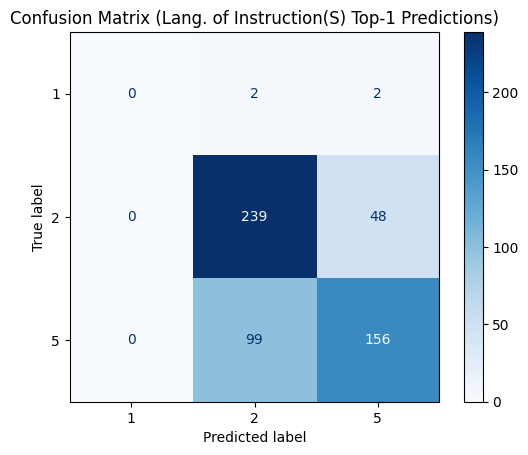

Evaluation Metrics: {'top1': {'accuracy': 0.7234432234432234, 'precision': 0.7304961790541459, 'recall': 0.7234432234432234, 'f1': 0.716810976315486}, 'top2': {'accuracy': np.float64(0.9926739926739927)}, 'top3': {'accuracy': np.float64(1.0)}}


In [9]:
data = list(df.keys())
settings = [0, 1]
y_cols = ['ESL Strategy', 'Curriculum', 'Physical Group',
          'Activity Structure', 'Mode', 'Language Content',
          'Lang. of Instruction(T)', 'Lang. of Instruction(S)']

df_merged = pd.concat([df['R1'], df['R2'], df['R3']])
df_merged = df_merged.reset_index(drop=True)


for rnd in ['R123']:
    for setting in settings:
        for target in y_cols:
            print(f"\n\n\n---------------------- Tokenize and save dataset {rnd}, Setting {setting}, {target} ----------------------")

            dataset_dir = f"./datasets0227_bert1/{rnd}/{setting}/{target}"
            output_dir = f"./models0227_bert1/{rnd}/{setting}/{target}"
            results_dir = f"./results0227_bert1/{rnd}/{setting}/{target}"
            os.makedirs(dataset_dir, exist_ok=True)
            os.makedirs(output_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)

                        
            label_encoder = LabelEncoder()
            df_merged["label"] = label_encoder.fit_transform(df_merged[target])
            
            # Save the label mapping to a JSON file
            label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
            mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
            with open(mapping_file_path, "w") as json_file:
                json.dump(label_mapping, json_file, indent=4)
            print(f"Label mapping saved to: {mapping_file_path}")

            num_labels = len(df_merged[target].unique())
            tokenize_and_save(df_merged, target, rnd, setting, video_path, results_dir, dataset_dir)
            training_evaluation(video_path, results_dir, output_dir, num_labels, label_mapping)